#### Step-by-Step Transfer Learning with PyTorch

We'll use ResNet18 (you can also try ResNet50 or EfficientNet later).

#### 1. Setup & Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os


#### 2. Configuration

In [2]:
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 50
LEARNING_RATE = 0.0001
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)


#### 3. Transforms & Data Loaders

Make sure image size matches pretrained model expectations: 224x224


In [3]:
train_transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.ColorJitter(0.2,0.2,0.2),
  transforms.ToTensor(),
  transforms.Normalize([0.485,0.456,0.406],
                       [0.229,0.224,0.225])
])

test_transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize([0.485,0.456,0.406],
                       [0.229,0.224,0.225])
])

In [4]:
train_dataset = datasets.ImageFolder("./dataset/train", transform=train_transform)

val_dataset = datasets.ImageFolder("./dataset/val", transform=test_transform)
test_dataset = datasets.ImageFolder("./dataset/test", transform=test_transform)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### 4. Load Pretrained Model (ResNet18)

In [6]:
model = models.resnet18(pretrained=True)

d:\AIML And DSA\AI Projects\FastAPI\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AIML And DSA\AI Projects\FastAPI\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Get in_features BEFORE replacing model.fc
in_features = model.fc.in_features

# Freeze earlier layers
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Now replace the classifier with a custom head
model.fc = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, NUM_CLASSES)
)

model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 5. Loss, Optimizer, Scheduler

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

#### 6. Training Loop

In [9]:
def train(model, train_loader, val_loader, epochs, patience=5):
    train_acc, val_acc = [], []
    best_val_acc = 0
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(imgs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(output, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_acc.append(100 * correct / total)

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        val_accuracy = 100 * correct / total
        val_acc.append(val_accuracy)
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_acc[-1]:.2f}%, Val Acc: {val_acc[-1]:.2f}%")

        # Early stopping logic
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            best_model_state = model.state_dict()  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model before returning
    if best_model_state:
        model.load_state_dict(best_model_state)

    return train_acc, val_acc


train_acc, val_acc = train(model, train_loader, val_loader, EPOCHS)


Epoch 1/50, Train Acc: 26.53%, Val Acc: 32.95%
Epoch 2/50, Train Acc: 36.99%, Val Acc: 44.32%
Epoch 3/50, Train Acc: 47.45%, Val Acc: 43.18%
Epoch 4/50, Train Acc: 53.32%, Val Acc: 54.55%
Epoch 5/50, Train Acc: 52.81%, Val Acc: 60.23%
Epoch 6/50, Train Acc: 58.16%, Val Acc: 63.64%
Epoch 7/50, Train Acc: 61.48%, Val Acc: 53.41%
Epoch 8/50, Train Acc: 65.56%, Val Acc: 60.23%
Epoch 9/50, Train Acc: 65.05%, Val Acc: 61.36%
Epoch 10/50, Train Acc: 67.60%, Val Acc: 68.18%
Epoch 11/50, Train Acc: 67.60%, Val Acc: 64.77%
Epoch 12/50, Train Acc: 68.88%, Val Acc: 64.77%
Epoch 13/50, Train Acc: 69.90%, Val Acc: 62.50%
Epoch 14/50, Train Acc: 66.07%, Val Acc: 60.23%
Epoch 15/50, Train Acc: 69.13%, Val Acc: 62.50%
Early stopping triggered at epoch 15


#### 7. Plot Accuracy Curve

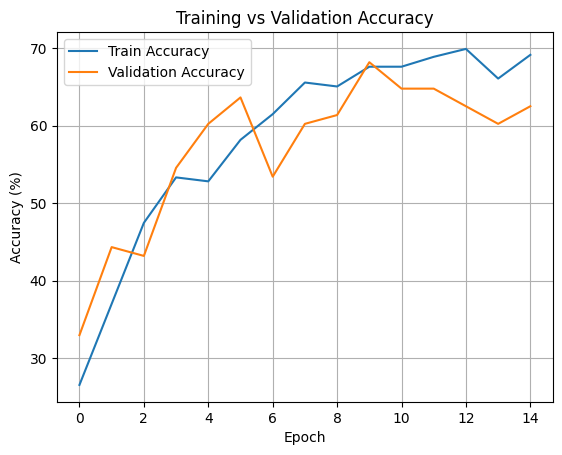

In [10]:
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#### 8. Evaluate on Test Set

In [11]:
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

evaluate(model, test_loader)


Test Accuracy: 62.50%


#### 9. Save Model

In [12]:
# torch.save(model.state_dict(), "resnet18_car_classifier.pth")

#### 10. Predict New Image

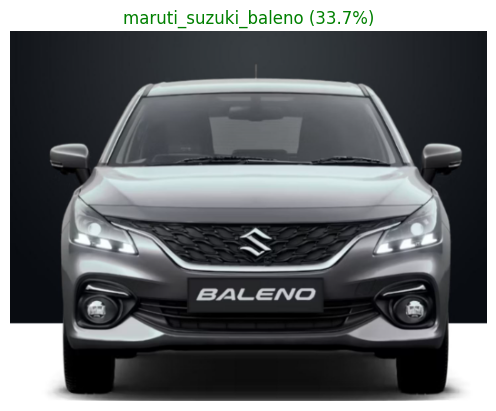

In [16]:
from PIL import Image

# Use same transform
predict_transform = test_transform
class_names = train_dataset.classes

def predict_image(image_path):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    img_tensor = predict_transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{class_names[pred.item()]} ({conf.item()*100:.1f}%)", color='green')
    plt.show()

# Example
predict_image("./image_sample/baleno.png")
